In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
from functions4 import *
from declarations2 import *
import numpy as np
import matplotlib.pyplot as plt
import healpy as H
import SkymapPlot.SkyMap
from SkymapPlot.coords import galactic

In [2]:
def HMS2deg(input_data ,mode="RA"):
    RA, DEC, rs, ds = '', '', 1, 1
    if mode=="Dec":
        D, M, S = [float(i) for i in input_data]
        if str(D)[0] == '-':
            ds, D = -1, abs(D)
        deg = D + (M/60) + (S/3600)
        DEC = '{0}'.format(deg*ds)
   
    elif mode=="RA":
        H, M, S = [float(i) for i in input_data]
        if str(H)[0] == '-':
            rs, H = -1, abs(H)
        deg = (H*15) + (M/4) + (S/240)
        RA = '{0}'.format(deg*rs)
    else:
        print " KEY ERROR"
    if RA=='':
        return float(DEC)
    else:
        return float(RA)
def getstrongestsources(NVSS, N=100):
    ind = np.argpartition(NVSS["Flux"], -N)[-N:]
    Flux=np.array(NVSS["Flux"])[ind]
    Zenith=np.array(NVSS["RA(2000)"])[ind]
    Azimuth=180/np.pi*dec2zen_noticecube(np.array(NVSS["Dec(2000)"])[ind]*np.pi/180)
    return Zenith,Azimuth
    


In [5]:
skip_line=16
a = open("/net/scratch_icecube4/user/glauch/NVSS/FullNVSSCat.text", 'r')
field_names=["RA(2000)", "Dec(2000)", "Flux"]
subnames=["h m s","d m s", "mJy"]
NVSS=dict()

temp_arrays=[]
for i in field_names:
    temp_arrays.append([])
    
##########Create Index Mask##################
index_mask=[]
for i in range(skip_line):
    a.readline()
subname_line=a.readline().split()
for subs in subnames:
    temp=subs.split()
    for x in temp:
        i=0
        while i<len(subname_line):
            if subname_line[i]==x:
                index_mask.append(i)
                subname_line[i]=' '
                break
            i=i+1

####Read Data from File and Convert to Degrees

for line in a:
    if field_names[0] in line or "h" in line or "page" in line :
        continue
    if len(line.split())<14:
        continue
    curind=0
    temp=line.split()
    for i,subs in enumerate(subnames):
        if len(subs.split())==3:
            if "RA" in field_names[i]:
                temp_arrays[i].append(HMS2deg([temp[index_mask[curind]],temp[index_mask[curind+1]],temp[index_mask[curind+2]]], mode="RA"))
            elif "Dec" in field_names[i]:
                temp_arrays[i].append(HMS2deg([temp[index_mask[curind]],temp[index_mask[curind+1]],temp[index_mask[curind+2]]], mode="Dec"))
            else:
                print "Key Error for transformation from HMS to DEG"
            curind+=3
        if len(subs.split())==1:
            if temp[index_mask[curind]][0]!="<":
                temp_arrays[i].append(float(temp[index_mask[curind]]))
            else:
                j=0
                while j<i:
                    del temp_arrays[j][-1]
                    j+=1

#######Write into the dictionary
for i in range(len(temp_arrays)):
    NVSS[field_names[i]]=temp_arrays[i]
    
#print NVSS

# Angle and Flux Histogramms

/cvmfs/icecube.opensciencegrid.org/py2-v2/RHEL_6_x86_64/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


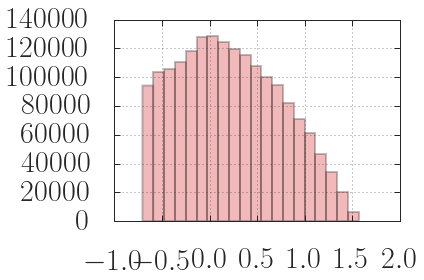

In [6]:
nbins=20
input_data=np.array(NVSS["Dec(2000)"])/90*np.pi/2
n, bins, _ = plt.hist(input_data, bins=nbins, alpha=0.3, range=(np.min(input_data),np.max(input_data)))

In [8]:
plt.show()

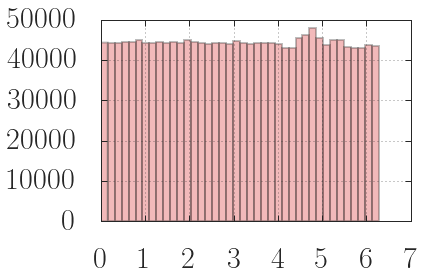

In [9]:
nbins=40
input_data=np.array(NVSS["RA(2000)"])/90*np.pi/2
n, bins, _ = plt.hist(input_data, bins=nbins, alpha=0.3, range=(np.min(input_data),np.max(input_data)))

In [10]:
plt.show()

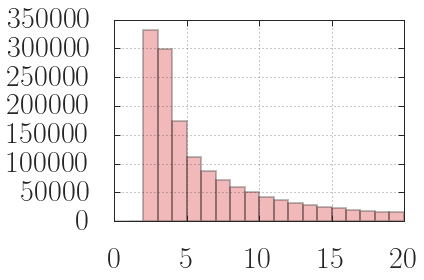

In [11]:
nbins=20
input_data=NVSS["Flux"]
n, bins, _ = plt.hist(input_data, bins=nbins, alpha=0.3, range=(0,20))

In [14]:
plt.show()

# Skymap

Sigma is 30.000000 arcmin (0.008727 rad) 
-> fwhm is 70.644601 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


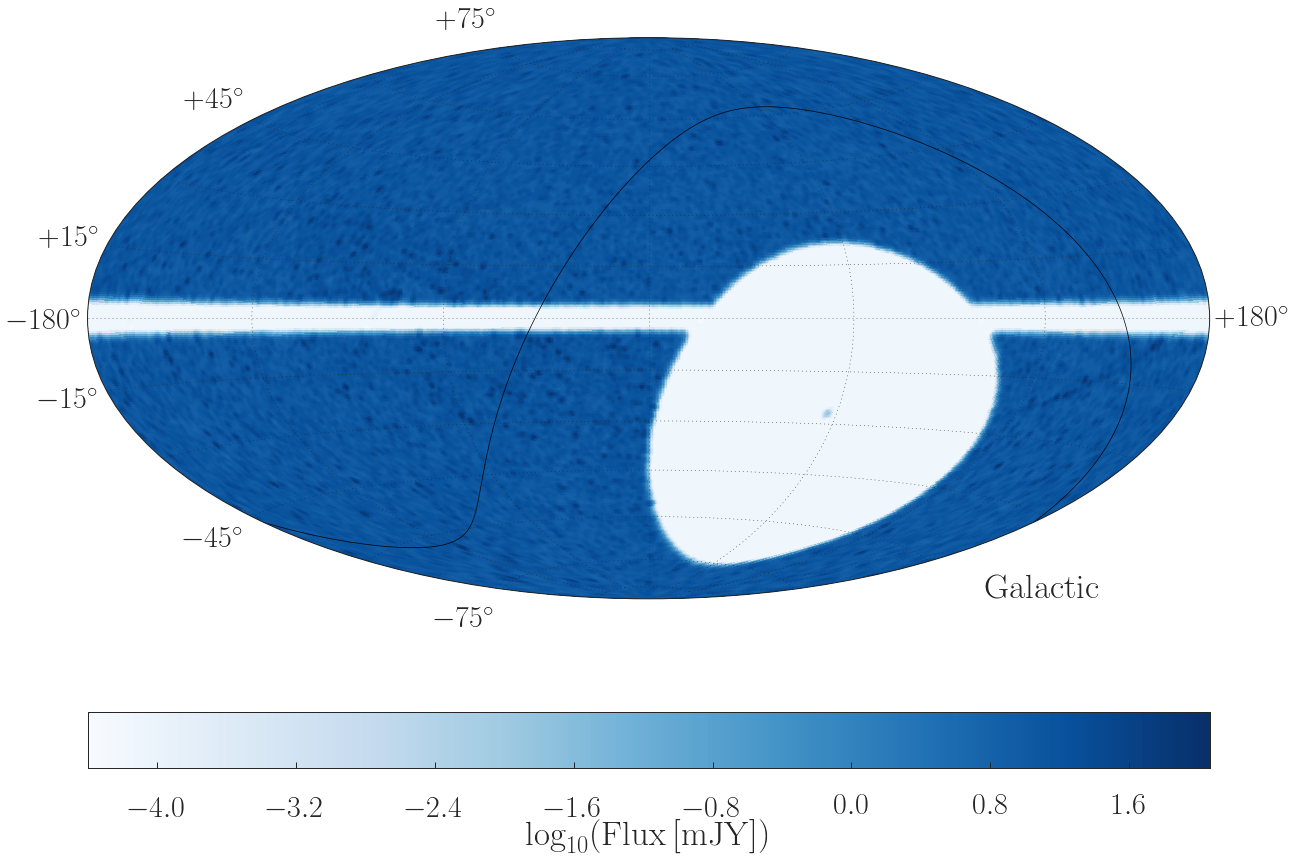

In [15]:
Galactic=True
PlaneCut=True
logz=True
SAVE_DIR = "/net/scratch_icecube4/user/glauch/SAVED/other_plots"
nFigure=2

###############Create Healpy Map##############
nside=512
npix=H.nside2npix(nside)
map_delta = np.zeros(npix)
declination_pre=np.array(NVSS["Dec(2000)"])*np.pi/180.
ra_pre=np.array(NVSS["RA(2000)"])*np.pi/180.
declination=[]
ra=[]
for i in range(len(declination_pre)):
    galcoord=galactic(ra_pre[i],declination_pre[i])[1]
    if galcoord>np.radians(5) or galcoord<np.radians(-5) or PlaneCut==False: 
        declination.append(declination_pre[i])
        ra.append(ra_pre[i])
declination=np.array(declination)
ra=np.array(ra)
hit_bool = H.ang2pix(nside,dec2zen_noticecube(declination),ra)
for i in range(len(hit_bool)):
        map_delta[hit_bool[i]] += NVSS["Flux"][i]
##################################################

plot=plotControl(nFigure)
Norm=None
if logz: Norm='log'

smoothed_map = H.smoothing(map_delta, sigma=np.radians(0.5))
if min(smoothed_map)<=0:
    raiser=abs(min(smoothed_map))*2
else:
    raiser = 0.
    
for i in range(len(smoothed_map)):
    smoothed_map[i] = float(smoothed_map[i])
    if logz:
        smoothed_map[i]=smoothed_map[i]+raiser

colormap=plt.get_cmap("Blues")
colormap.set_under("1")
col2="0."
col="0."
res=800


if Galactic==False:
    skymap=SkymapPlot.SkyMap.SkyMap(fig=plot)
    skymap.plot_map(np.log10(smoothed_map),
                    cmap=colormap, npix=res, 
                    colorbar=dict(title=r"$\log_{10}(\mathrm{Flux}\,[\mathrm{mJY}])$"))
    #skymap.fig.savefig("test.png", dpi=800, bbox_inches="tight")
else:
    skymap=SkymapPlot.SkyMap.SkyMapGalactic(fig=plot)
    skymap.add_plane()
    skymap.plot_map(np.log10(smoothed_map),
                    cmap=colormap, npix=res, 
                    colorbar=dict(title=r"$\log_{10}(\mathrm{Flux}\,[\mathrm{mJY}])$"))
    #skymap.fig.savefig("test.png", dpi=800, bbox_inches="tight")


In [22]:
plt.show()

In [17]:
Cl=H.anafast(map_delta, lmax=1000)

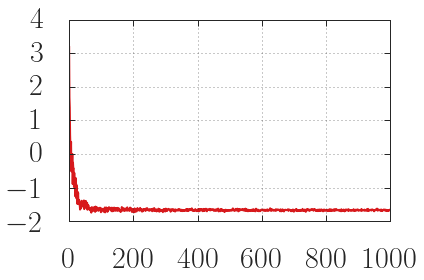

In [18]:
l=1000
Cls=Cl[:1000]

plt.plot(range(l), np.log10(np.array(Cls)))
plt.show()

In [19]:
NVSS=readNVSS()
a,_=getstrongestsources(NVSS, N=10)

In [20]:
print len(NVSS["Flux"])
print len(NVSS["RA(2000)"])
print len(NVSS["Dec(2000)"])


1184383
1184383
1184383


In [21]:
print np.cos(a)

[ 0.17977954  0.99553333  0.3058336   0.52818892 -0.81421821 -0.41099449
  0.57078887 -0.20288622 -0.9431039   0.99977046]
